## Model Selection

In [25]:
%load_ext autoreload
%autoreload 2
import math
import numpy as np
import torch
from torch import nn
import d2l

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Our true function will be $ y = 5 + 1.2x - 3.4 \frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon$

In [26]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test,1))
np.random.shuffle(features)
# Create array of shape (n_train+n_test, max_degree)
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))

for i in range(max_degree):
    #`gamma(n)` = (n-1)!
    # Rescale to avoid very large values of gradients or losses
    poly_features[:, i] /= math.gamma(i + 1)
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size = labels.shape)

In [27]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype = torch.float32)
    for x in [true_w, features, poly_features, labels]]

In [28]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.9092],
         [-0.1839]]),
 tensor([[ 1.0000e+00,  1.9092e+00,  1.8225e+00,  1.1599e+00,  5.5360e-01,
           2.1139e-01,  6.7264e-02,  1.8346e-02,  4.3782e-03,  9.2877e-04,
           1.7732e-04,  3.0777e-05,  4.8966e-06,  7.1912e-07,  9.8067e-08,
           1.2482e-08,  1.4894e-09,  1.6727e-10,  1.7742e-11,  1.7828e-12],
         [ 1.0000e+00, -1.8392e-01,  1.6913e-02, -1.0369e-03,  4.7677e-05,
          -1.7538e-06,  5.3759e-08, -1.4125e-09,  3.2473e-11, -6.6361e-13,
           1.2205e-14, -2.0407e-16,  3.1277e-18, -4.4250e-20,  5.8132e-22,
          -7.1278e-24,  8.1935e-26, -8.8644e-28,  9.0575e-30, -8.7676e-32]]),
 tensor([7.5837, 4.7985]))

In [29]:
# @save
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2) # store loss and number of examples
    for X, y in data_iter:
        output = net(X)
        y = y.reshape(output.shape)
        l = loss(output, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [30]:
def train(train_features, test_features, 
          train_labels, test_labels, num_epochs = 400):
    loss = nn.MSELoss(reduction='none') #don't take average or sum
    input_shape = train_features.shape[-1]
    # bias is included in polynimial features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), 
                                batch_size, is_train=True)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

#### Third order polynomial

weight: [[ 4.993671   1.2405995 -3.3956282  5.487436 ]]


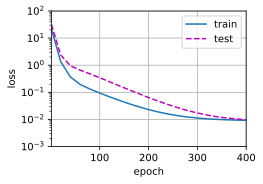

In [31]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

#### Linear

weight: [[3.565309 4.355988]]


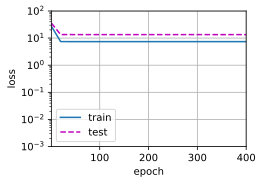

In [13]:
train(poly_features[:n_train,:2], poly_features[n_train:, :2],
     labels[:n_train], labels[n_train:])

#### Higher order polynomials

weight: [[ 4.9918065   1.2704682  -3.2500246   5.0957932  -0.6698962   1.5109148
  -0.02936444  0.28687078  0.14806628 -0.10482892  0.10053237  0.20081198
  -0.00754834 -0.20315483  0.04802608  0.12071671 -0.01293205 -0.17698161
  -0.17848147  0.08763515]]


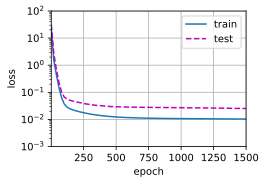

In [15]:
train(poly_features[:n_train,:], poly_features[n_train:, :],
     labels[:n_train], labels[n_train:], num_epochs=1500)

## Weight Decay

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
import d2l

#%config Completer.use_jedi = False

Generate data $ y = 0.05 + \sum_{i=1}^{d} {0.01} x_{i} + \epsilon $ where $ \epsilon ~ N(0, 0.01^2) $

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs,1)) * 0.01, 0.05

train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size, is_train=True)

test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
# implement from scratch
def init_params():
    w = torch.normal(0, 1, size=(num_inputs,1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [5]:
def train(lambd):
    w, b = init_params()
    # loss is set to a function below
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                           xlim=[5, num_epochs],ylim=[1e-5, 1e3],
                            legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # The L2 norm penalty term has been added, and broadcasting
            # makes `l2_penalty(w)` a vector whose length is `batch_size`
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch+1 , (d2l.evaluate_loss(net, train_iter, loss),
                                   d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())

L2 norm of w: 13.57049560546875


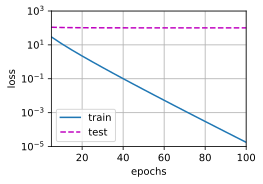

In [35]:
train(lambd=0)

L2 norm of w: 0.3597319722175598


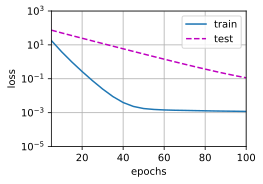

In [36]:
train(lambd=3)

#### Concise Implementation

In [10]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs,1))
    # initialize the parameters with N(0,1)
    for param in net.parameters():
        param.data.normal_()
    # calculate loss for each element (do not average or sum)
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # the bias parameter will not be decayed. We can use dictionary to specify additional parameters
    trainer = torch.optim.SGD([
        {"params": net[0].weight, 'weight_decay': wd},
        {"params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss',yscale='log',
                           xlim=[5, num_epochs], ylim=[1e-8, 1e3], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                    d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())

L2 norm of w: 13.896258354187012


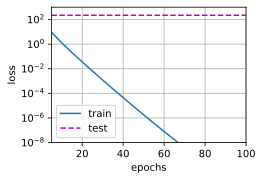

In [11]:
train_concise(0)

L2 norm of w: 0.41151708364486694


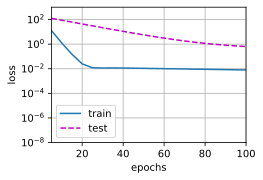

In [12]:
train_concise(3)

### Dropout

#### From Scratch

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
import d2l

In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # in this case all elements are dropped out
    if dropout == 1:
        return torch.zeros_like(X)
    # in this case all elements are kept
    if dropout == 0:
        return X
    # draw from Uniform distribution and check if > than dropout value
    mask = (torch.rand(X.shape) > dropout).float()
    # rescale by (1.0 - dropout) to preserve the expected value of the layer
    return mask * X / (1.0 - dropout)

We can test out the dropout_layer function on a few examples. In the following lines of code, we pass our input X through the dropout operation, with probabilities 0, 0.5, and 1, respectively.

In [25]:
X = torch.arange(16, dtype = torch.float32).reshape(2,8)
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  0.,  8.,  0.,  0., 14.],
        [16., 18., 20.,  0., 24.,  0., 28.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [26]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [43]:
# Defining the Model

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs,
                num_hiddens1, num_hiddens2, isTraining=True):
        # first argument to super must be type
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = isTraining
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, num_inputs))))
        # Use dropout only when training the model
        if self.training == True:
            # Add a dropout layer after the first FC Layer
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # Add a dropout layer after the second FC Layer
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

In [44]:
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

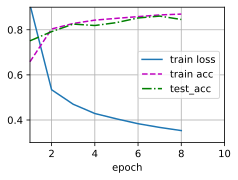

In [ ]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction = 'none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

#### Concise Implementation

In [29]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    # Add a dropout layer after the first FC Layer
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    # Add a dropout layer after the second FC Layer
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights);

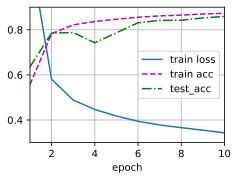

In [31]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)